# Collections of Neurons

[Last time](./08%20-%20Encoding%20and%20Decoding%20Information.ipynb), we saw how a single neuron was able to "encode" information in its spike train and how we could compute a "decoder". We use the same LIF and Synapse models as before (but adding an extra `reset` function for the LIF):

In [1]:
import math

def signal(t):
    return 2 * math.sin(t)

class FirstOrderLIF: # First Order Leaky Integrate and Fire
    def __init__(self, tau_rc=0.2, tau_ref=0.002, v_init=0, v_th=1):
        self.tau_rc  = tau_rc  # Potential decay time constant
        self.v       = v_init  # Potential value
        self.v_th    = v_th    # Firing threshold
        self.tau_ref = tau_ref # Refractory period time constant

        self.output          = 0 # Current output value
        self.refractory_time = 0 # Current refractory period time (how long until the neuron can fire again)
    
    def step(self, I, t_step): # Advance one time step (input I and time step size t_step)
        self.refractory_time -= t_step # Subtract the amount of time that passed from our refractory time

        if self.refractory_time < 0: # If the neuron is not in its refractory period
            self.v = self.v * (1 - t_step / self.tau_rc) + I * t_step / self.tau_rc # Integrate the input current
        
        if self.v > self.v_th: # If the potential is above the threshold
            self.refractory_time = self.tau_ref # Enter the refractory period
            self.output = 1 / t_step            # Emit a spike
            self.v = 0                          # Reset the potential
        else: # If the potential is below the threshold
            self.output = 0 # Do not fire
        
        return self.output
    
    def reset(self): # Reset the neuron to its initial state
        self.v = self.output = self.refractory_time = 0

class FirstOrderSynapse:
    def __init__(self, tau_s=0.01):
        self.tau_s  = tau_s # Synaptic time constant
        self.output = 0     # Current potential

    def step(self, I, t_step):
        self.output = self.output * (1 - t_step / self.tau_s) + I * t_step / self.tau_s # Decay potential
        return self.output
    
    def reset(self): # Reset the synapse to its initial state
        self.output = 0

If we look at [the tuning curve of a neuron](./06%20-%20Firing%20Rates%20and%20Tuning%20Curves.ipynb) (how it responds to different input values), we get:

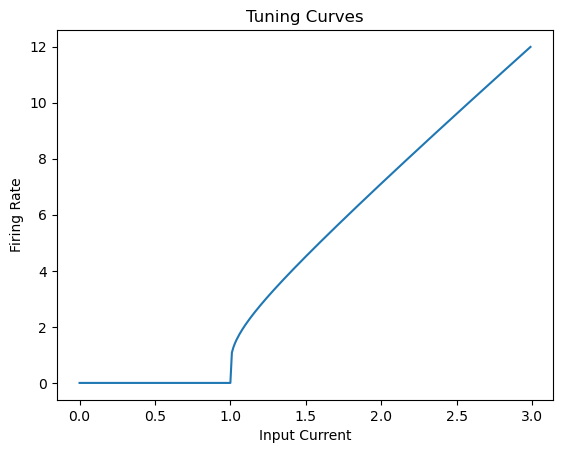

In [2]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)

def computeTuningCurve(lif, inputs, time_limit = 1, t_step = 0.001):
    tuningCurve = []
    for inp in inputs:
        spike_count = 0
        lif.reset()
        for _ in np.arange(0, time_limit, t_step):
            output = lif.step(inp, t_step)
            if output > 0:
                spike_count += 1
        rate = spike_count / time_limit
        tuningCurve.append(rate)
    lif.reset()

    return tuningCurve

def analyticalRate(neuron, I):
    if I <= neuron.v_th: return 0
    else:                return 1 / (neuron.tau_ref - neuron.tau_rc * np.log(1 - neuron.v_th/I))

neuron = FirstOrderLIF()

inputs = np.arange(0, 3, 0.01)
# tuningCurve = computeTuningCurve(neuron, inputs)
tuningCurve = [analyticalRate(neuron, i) for i in inputs]

plt.figure()
plt.plot(inputs, tuningCurve)
plt.xlabel('Input Current')
plt.ylabel('Firing Rate')
plt.title('Tuning Curves')
plt.show()

The decoder is 0.3229210069532396


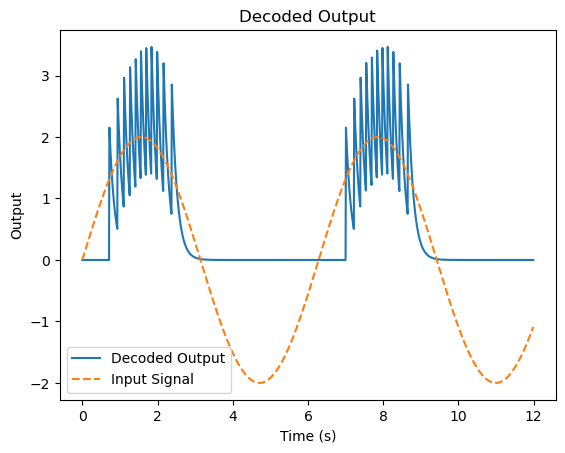

In [3]:
psp = FirstOrderSynapse(tau_s = 0.15)

def computeDecoder(neuron, range_low=-1, range_high=1, interval=0.1):
    numerator   = 0
    denominator = 0
    for i in np.arange(range_low, range_high, interval):
        r = analyticalRate(neuron, i)
        numerator   += r*i
        denominator += r*r
    return numerator / denominator

# plot signal vs time for 12 seconds
t_step = 0.01
t = np.arange(0, 12, t_step)
decoder = computeDecoder(neuron, -2, 2)
print(f"The decoder is {decoder}")
signal_out = []
decoded_output = []
for i in t:
    sig = signal(i)
    neuron.step(sig, t_step)
    psp.step(neuron.output, t_step)
    signal_out.append(sig)
    decoded_output.append(decoder * psp.output)

plt.figure()
plt.plot(t, decoded_output)
plt.plot(t, signal_out, linestyle="--")
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.title('Decoded Output')
plt.legend(['Decoded Output', 'Input Signal'])
plt.show()

So far, we have focused on single neurons but in order to convey information effectively, we need **populations** of neurons---not just one. In other words, we are going to move from using one neuron to using many neurons to better represent (and later on, process) our signals. If we work with a population of neurons, each neuron should react differently to the same input (meaning they should have different tuning curves). If two neurons had the exact same tuning curve, they aren't conveying any more information than one neuron. This should convey more information than just one neuron, which we can verify by decoding the signals of multiple neurons.

Now that we're working with multiple neurons, we will also start using the subscript $_{i}$ to represent neuron $i$. We'll also add three additional terms to scale the input of every neuron:
- $\alpha_i$: the **gain**---a multiplicative factor that scales the input
- $e_i$: the **encoder**---a scale that decides what "direction" our neuron responds to (in our case, it will be either $1$ or $-1$ to specify if it fires more for positive or negative inputs?)
- $b_i$: the **bias**---an bias that we add to the input


This means that for input $x$, the effective input for neuron $i$ will be $e_{i}\alpha_{i}x + b_i$.

:::{note} 

If $e_{i}$ is negative, our neuron will fire *more* frequently for negative inputs. Although this does not necessarily make sense in the context of a single isolated neuron, (1) biological realism is not our primary goal and (2) it might correspond to a situation where there is some constant background current and an inhibitory background current.

It might also seem strange that we separate the gain $\alpha_{i}$ from the encoder $e_{i}$, with $e$ representing the "direction" that our neuron responds to and $\alpha$ representing the scale {cite}`stewart2012technical`. It will make more sense to do this when we have *multiple* inputs and there's a notion of "direction" (in other words, how does our neuron react to each input).
:::

Since it can be a little easier to specify the "intercept" ($x_{int}$---the input where our neuron starts firing) and the maximum firing rate ($r_{max}$---how fast our neuron can fire for the inputs we expect), we can write a function (`getGainBias`) to compute the values of $\alpha_i$ and $b_i$ from $r_{max}$, $x_{int}$, and information about the neuron---$\tau_{rc}$, $\tau_{ref}$, and $v_{th}$:

In [1]:
def getGainBias(maxRate, intercept, tau_rc, tau_ref, v_th):
    gain = v_th * (1 - 1 / (1 - np.exp((tau_ref - 1/maxRate) / tau_rc))) / (intercept - 1)
    bias = v_th - gain * intercept

    return gain, bias


:::{dropdown} Where does this code/math for computing the gain and bias come from?

## Computing Scales and Biases (Optional)
We could randomly select values of $\alpha_i$ and $b_i$ but let's instead compute them from:

- A desired maximum firing rate in the context of an interval, which we will call $r_{max}$
- A desired intercept, where our neuron starts firing, which we will call $x_{int}$

We can analytically determine $r(I)$ to estimate a firing rate {eq}`eq:analytical-rate`:

$$r(I) =
\begin{cases}
  0, & \text{if } I \leq v_{th}{}\\
  \frac{1}{\tau_{ref}-\tau_{rc}\ln{\left(1 - \frac{v_{th}}{I}\right)}}, & \text{otherwise}
\end{cases}$$

We can turn this equation around to ask what **input current** do we need to achieve a given firing rate. In other words, we can leave $r(I)$ fixed (at $r$) and solve for $I$. If we do this on the above equation, we get:

$$I = \frac{v_{th}}{1 - e^{\frac{\tau_{ref} - \frac{1}{r}}{\tau_{rc}}}}$$

Let's call this $z(r)$ for short:

$$z(r) = \frac{v_{th}}{1 - e^{\frac{\tau_{ref} - \frac{1}{r}}{\tau_{rc}}}}$$

Recall that our effective input given input $x$ is $I$:

$$I(x) = \alpha x + b$$

Let's suppose that we only care about the possible inputs up to $1$. This means that our maximum rate, $r_{max}$ should be achieved at input $x=1$:

$$I_i(1) = 1\alpha_i + b = z(r_{max})$$

or re-arranging:

$$b = z(r_{max}) - \alpha$$

But we know that at our intercept $x_{int}$, we should not fire, meaning that it is **right** at the threshold of our firing voltage, $v_{th}$: $I(x_{int}) = v_{th}$. So we have:

$$I(x_{int}) = v_{th} = \alpha{}x_{int} + b$$

or re-arranging:

$$b = v_{th} - \alpha{}x_{int}$$

Putting both equations for $b$ together, we get:

$$z(r_{max}) - \alpha = v_{th} - \alpha{}x_{int}$$

...re-arranging:

$$
\begin{align}
\alpha &= \frac{v_{th} - z(r_{max})}{x_{int} - 1} \\
       &= v_{th}\frac{1 - \frac{1}{1 - e^{\frac{\tau_{ref} - \frac{1}{r}}{\tau_{rc}}}}}{x_{int}-1} \\
\end{align}
$$

and

$$b = v_{th} - \alpha{}x_{int}$$
:::

Let's then write code for representing a collection of that creates a collection of neurons with different tuning curves

In [5]:
class FirstOrderLIFCollection: # Collection of First Order Leaky Integrate and Fire Neurons
    def __init__(self, num_neurons, tau_rc=0.02, tau_ref=0.002, v_th=1, max_rate_range = (200, 400), intercept_range = (-1, 1), encoder_options = (-1, 1)):
        self.neurons  = [] # List of neurons
        self.gains    = [] # List of gains (numbers)
        self.biases   = [] # List of biases (numbers)
        self.encoders = [] # List of encoders (numbers)

        for _ in range(num_neurons):
            neuron = FirstOrderLIF(tau_rc=tau_rc, tau_ref=tau_ref, v_th=v_th)
            max_rate  = np.random.uniform(max_rate_range[0], max_rate_range[1])   # Maximum firing rate
            intercept = np.random.uniform(intercept_range[0], intercept_range[1]) # Intercept (where the neuron starts firing)
            encoder   = np.random.choice(encoder_options)                         # Encoder (direction of the neuron's tuning curve) 

            gain, bias = getGainBias(max_rate, intercept, tau_rc, tau_ref, v_th)

            self.neurons.append(neuron)
            self.gains.append(gain)
            self.biases.append(bias)
            self.encoders.append(encoder)
    
    def step(self, I, t_step):
        outputs = []
        for neuron, gain, bias, encoder in zip(self.neurons, self.gains, self.biases, self.encoders): # Loop over neurons, gains, biases, and encoders
            output = neuron.step(I * gain * encoder + bias, t_step) # Step the neuron with the input scaled by the gain and encoder, plus the bias
            outputs.append(output) # Append the output to the list of outputs
        return outputs
    
    def reset(self): # Reset all neurons to their initial state
        for neuron in self.neurons:
            neuron.reset()

Let's then create a collection of ten neurons with different tuning curves.

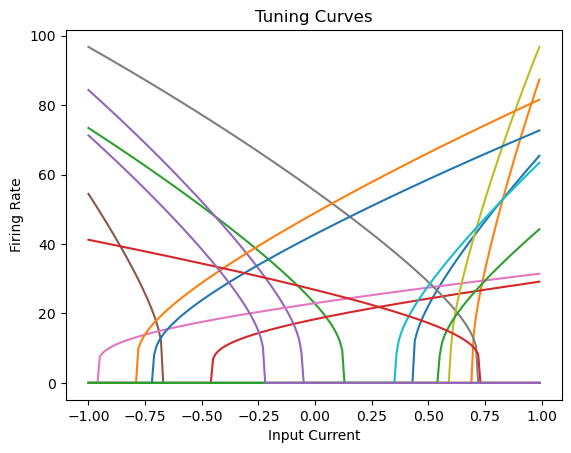

In [6]:
NUM_NEURONS = 15 
lifs = FirstOrderLIFCollection(NUM_NEURONS, max_rate_range=(25, 100))

def computeTuningCurves(lifs, inputs, time_limit = 1, t_step = 0.001):
    tuning_curves = [ [0] * len(inputs) for _ in range(len(lifs.neurons)) ]
    num_neurons = len(lifs.neurons)
    for inp_idx, inp in enumerate(inputs):
        spike_counts = [0] * num_neurons
        lifs.reset()
        for _ in np.arange(0, time_limit, t_step):
            outputs = lifs.step(inp, t_step)
            for i in range(num_neurons):
                if outputs[i] > 0:
                    spike_counts[i] += 1
        for i in range(num_neurons):
            tuning_curves[i][inp_idx] = spike_counts[i] / time_limit
    lifs.reset()

    return tuning_curves

inputs = np.arange(-1, 1, 0.01)

plt.figure()
# for curve in computeTuningCurves(lifs, inputs):
#     plt.plot(inputs, curve)
for neuron, gain, bias, encoder in zip(lifs.neurons, lifs.gains, lifs.biases, lifs.encoders):
    tuning_curve = [analyticalRate(neuron, i * gain * encoder + bias) for i in inputs]
    plt.plot(inputs, tuning_curve)

plt.xlabel('Input Current')
plt.ylabel('Firing Rate')
plt.title('Tuning Curves')
plt.show()

As we can see, all the neurons have different tuning curves as a result of their random gains, biases, and encoders.

Let's then also define a `FirstOrderSynapseCollection` class that will represent a collection of synapses for these neurons.

In [7]:
class FirstOrderSynapseCollection:
    def __init__(self, num_neurons, tau_s=0.05):
        self.synapses = [FirstOrderSynapse(tau_s) for _ in range(num_neurons)]
    
    def step(self, inputs, t_step):
        outputs = []
        for i, synapse in enumerate(self.synapses):
            inp = inputs[i]
            output = synapse.step(inp, t_step)
            outputs.append(output)
        return outputs
    
    def reset(self):
        for synapse in self.synapses:
            synapse.reset()

Then, let's create a collection of synapses and see what happens with a signal.

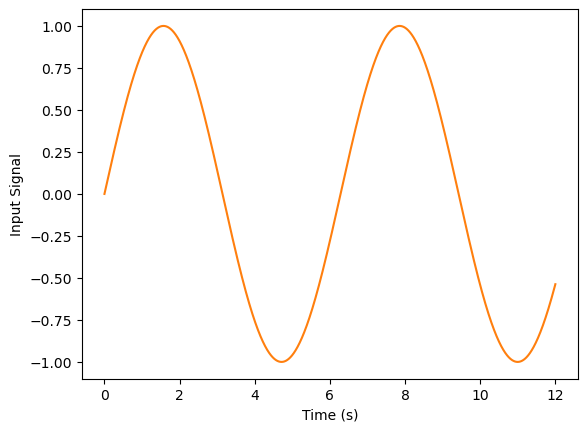

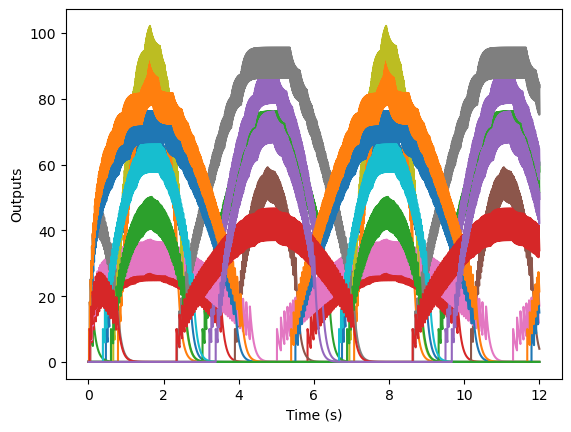

In [8]:
def signal(t):
    return math.sin(t)

synapses = FirstOrderSynapseCollection(NUM_NEURONS, tau_s=0.1)

def step(lifs, synapses, input_value, t_step):
    lif_outputs     = lifs.step(input_value, t_step)
    synapse_outputs = synapses.step(lif_outputs, t_step)
    return synapse_outputs

T_step = 0.001
T = np.arange(0, 12, T_step)

signals = []
outputs = []
for t in T:
    input_value = signal(t)
    out = step(lifs, synapses, input_value, T_step)
    signals.append(input_value)
    outputs.append(out)

plt.figure()
plt.plot(T, signals, color="C1")
plt.xlabel('Time (s)')
plt.ylabel('Input Signal')
plt.show()

plt.figure()
plt.plot(T, outputs)
plt.xlabel('Time (s)')
plt.ylabel('Outputs')
plt.show()

Now, if we want to try to re-construct the original signal from these neurons' outputs, we need to compute the decoders for **multiple** neurons. The procedure is similar to [what we did with one neuron](./08%20-%20Encoding%20and%20Decoding%20Information.ipynb), except that now we are minimizing the error across several neurons. So now, if we have $n$ neurons, our decoders $\vec{\phi}$ will be a vector rather than a single number. We use $\phi_i$ to refer to the decoder for neuron $i$.

:::{dropdown} What's the math behind computing $\vec{\phi}$?
## Computing Population Decoders (Optional)

When we want to compute the decoders for **multiple** neurons, the procedure is similar as it was for one neuron. However, now we are minimizing the error across several neurons. So now, if we have $n$ neurons, our decoders $\vec{\phi}$ will be a vector rather than a single number. We use $\phi_i$ to refer to the decoder for neuron $i$.

$$E = \int_{\text{low}}^{\text{high}} \frac{1}{2}[x - \sum_{i=1}^{n} r_i(x)\phi_i]^2 \,dx$$

We could minimize this procedurally (for example, through gradient descent) or analytically. For large numbers of neurons, it's probably best to do it procedurally but let's instead do it analytically. We want to find the optimal values for each $\phi_i$ by looking for the point where $\frac{\partial{}E(j)}{\partial{}\phi_i} = 0$.

$$\frac{\partial{}E(x)}{\partial{}\phi_i} = \int_{\text{low}}^{\text{high}} -2r_i(x)\frac{1}{2}[x - \sum_{j=1}^{n} r_j(x)\phi_j] \,dx$$

If we set this equal to zero, we have:

$$\int xr_i(x)dx = \int[r_i(x)\sum_{j=1}^{n}r_j(x)\phi_j] \,dx$$

re-arranging

$$\int xr_i(x)dx = \sum_{j=1}^{n}[\int r_i(x)r_j(x) \,dx]\phi_i$$

If we define matrices $\Upsilon{}$ and $\Gamma{}$ as follows:

$$\Gamma_{ij} = \int r_i(x)r_j(x)dx$$

and

$$\Upsilon_i = \int xr_i(x)dx$$

then we get

$$\Upsilon = \Gamma \phi$$

or

$$\phi = \Gamma^{-1} \Upsilon$$

We can estimate the integrals for $\Gamma$ and $\Upsilon$ through summation.

Two more notes:

1. [Some sources](https://link.springer.com/article/10.1007/BF00962720) recommend adding random noise to be more sure that $\Gamma$ is invertible. They recommend adding $\sigma{}$, the standard deviation of the noise to the diagonal so we will use $\Gamma + I$ where $I$ is the identity matrix.

2. Our computation of $\vec{\phi}$ is slightly inaccurate, especially for large numbers of neurons because of some implementation details (the library we use for matrix inversion is not precise...[the optional section below](https://observablehq.com/d/e363ce6cdb928f48?collection=@soney/neuromorphic-computing#cell-399) discusses why we use matrix inversion).
:::

In [9]:
import numpy as np

def getDecoders(lifs, minJ=-1, maxJ=1, stepSize=0.01):
    inputs = np.arange(minJ, maxJ, stepSize)

    # tuningCurves = computeTuningCurves(lifs, inputs)
    tuningCurves = []
    for neuron, gain, bias, encoder in zip(lifs.neurons, lifs.gains, lifs.biases, lifs.encoders):
        tuningCurves.append([analyticalRate(neuron, i * gain * encoder + bias) for i in inputs])

    A = np.array(tuningCurves)

    value = np.expand_dims(inputs, axis=1)
    Gamma = A @ A.T + np.identity(len(lifs.neurons))
    GammaInv = np.linalg.inv(Gamma)
    Upsilon = A @ value

    Phi = GammaInv @ Upsilon

    return Phi

Phi = getDecoders(lifs)
print(f"Phi is: {Phi.flatten()}")

Phi is: [ 1.25173521e-05  1.82993317e-03 -5.10319914e-03  1.50262571e-03
 -1.00303516e-03  2.88883235e-04  5.12202562e-03 -9.81927479e-03
 -5.44357947e-04  4.34728325e-03  1.89612567e-03  2.78694925e-03
  2.72645357e-04  1.10751640e-02 -8.00340690e-04]


We can use our weights $\vec{\phi}$ to try to re-construct the original signal by taking the outputs (`outputs`) and doing matrix multiplication with $\vec{\phi}$:

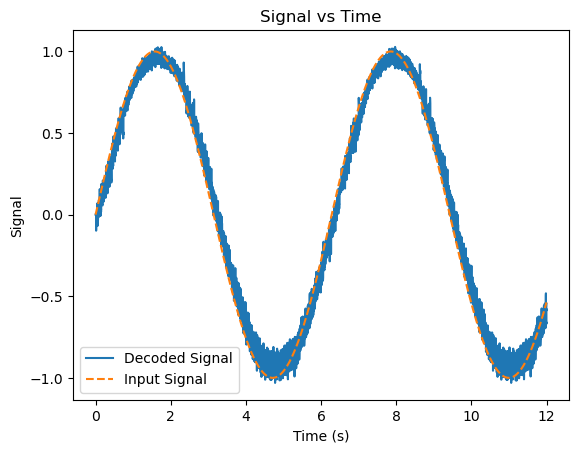

In [10]:
plt.figure()
plt.plot(T, outputs @ Phi) # Multiply the outputs by the decoders with matrix multiplication
plt.plot(T, signals, linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Signal')
plt.title('Signal vs Time')
plt.legend(['Decoded Signal', 'Input Signal'])
plt.show()

As we can see, even with a small number of neurons, we can re-construct our original input signal fairly well. If we added more neurons, our representation would improve.

Also, our time constant $\tau_s$ has an interesting effect on our output. As we decrease its value, our representation gets a little "rougher", since our PSP decays faster our representation ends up being jerkier. If we increase $\tau_s$, we end up with a smoother representation but it becomes increasingly time-delayed and is slower to "react" to the input. The example below shows the output for a large value of $\tau_s$ (prior value: `0.1`, new value: `1.0`):

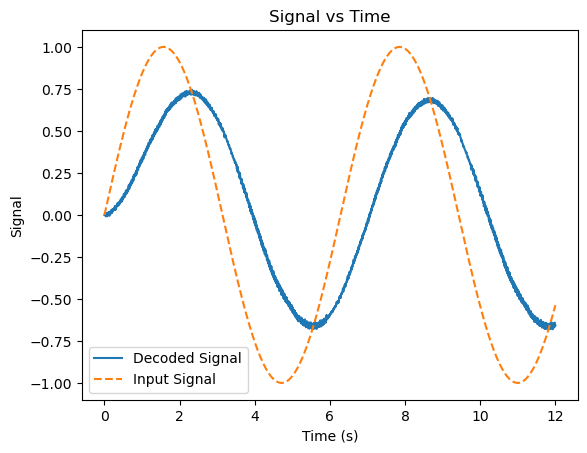

In [11]:
lifs = FirstOrderLIFCollection(NUM_NEURONS, max_rate_range=(25, 100))
synapses = FirstOrderSynapseCollection(NUM_NEURONS, tau_s=1)

signals = []
outputs = []
for t in T:
    input_value = signal(t)
    out = step(lifs, synapses, input_value, T_step)
    signals.append(input_value)
    outputs.append(out)

Phi = getDecoders(lifs)

plt.figure()
plt.plot(T, outputs @ Phi)
plt.plot(T, signals, linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Signal')
plt.title('Signal vs Time')
plt.legend(['Decoded Signal', 'Input Signal'])
plt.show()

Let's see what this looks like with a stranger signal (and up the number of neurons a bit to `50`):

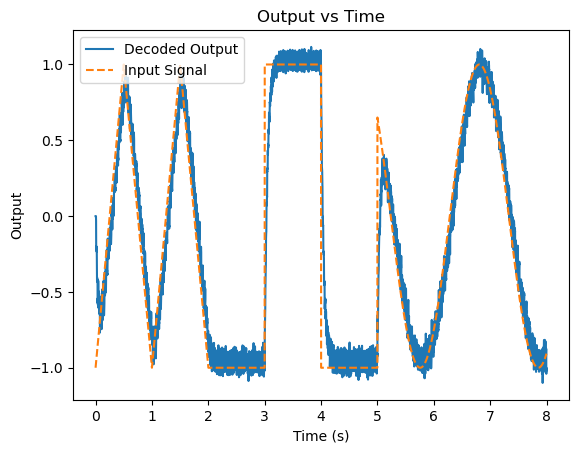

In [13]:
lifs = FirstOrderLIFCollection(50, max_rate_range=(25, 100))
synapses = FirstOrderSynapseCollection(50)

def signal2(t): # Create a (strange) signal
    if t < 2:
        return 1 - 4 * abs((t%1) - 0.5) # Triangle wave for first two seconds
    elif t < 5:
        return -1 if (t % 2) < 1 else 1 # Square wave for the next three seconds
    else:
        return math.sin(t*3) # Sine wave for the remainder

T_step = 0.001
T = np.arange(0, 8, T_step)
signals = []
outputs = []
for t in T:
    sig = signal2(t)
    out = step(lifs, synapses, sig, T_step)
    signals.append(sig)
    outputs.append(out)

Phi = getDecoders(lifs)
decoded_output = outputs @ Phi

plt.figure()
plt.plot(T, decoded_output)
plt.plot(T, signals, linestyle="--")
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.title('Output vs Time')
plt.legend(['Decoded Output', 'Input Signal'])
plt.show()

```{editor} python
:packages: matplotlib,numpy
:run_on_load: true
:max_height: 600px

import matplotlib.pyplot as plt
import numpy as np
import math

NUM_NEURONS =     5 #<-SLIDE(2 to 50 by 1)
tau_s       = 0.100 #<-SLIDE(0.010 to 1 by 0.01)

def getGainBias(maxRate, intercept, tau_rc, tau_ref, v_th):
    gain = v_th * (1 - 1 / (1 - np.exp((tau_ref - 1/maxRate) / tau_rc))) / (intercept - 1)
    bias = v_th - gain * intercept

    return gain, bias

class FirstOrderLIF: # First Order Leaky Integrate and Fire
    def __init__(self, tau_rc=0.2, tau_ref=0.002, v_init=0, v_th=1):
        self.tau_rc  = tau_rc  # Potential decay time constant
        self.v       = v_init  # Potential value
        self.v_th    = v_th    # Firing threshold
        self.tau_ref = tau_ref # Refractory period time constant

        self.output          = 0 # Current output value
        self.refractory_time = 0 # Current refractory period time (how long until the neuron can fire again)
    
    def step(self, I, t_step): # Advance one time step (input I and time step size t_step)
        self.refractory_time -= t_step # Subtract the amount of time that passed from our refractory time

        if self.refractory_time < 0: # If the neuron is not in its refractory period
            self.v = self.v * (1 - t_step / self.tau_rc) + I * t_step / self.tau_rc # Integrate the input current
        
        if self.v > self.v_th: # If the potential is above the threshold
            self.refractory_time = self.tau_ref # Enter the refractory period
            self.output = 1 / t_step            # Emit a spike
            self.v = 0                          # Reset the potential
        else: # If the potential is below the threshold
            self.output = 0 # Do not fire
        
        return self.output
    
    def reset(self): # Reset the neuron to its initial state
        self.v = self.output = self.refractory_time = 0

class FirstOrderSynapse:
    def __init__(self, tau_s=0.01):
        self.tau_s  = tau_s # Synaptic time constant
        self.output = 0     # Current potential

    def step(self, I, t_step):
        self.output = self.output * (1 - t_step / self.tau_s) + I * t_step / self.tau_s # Decay potential
        return self.output
    
    def reset(self): # Reset the synapse to its initial state
        self.output = 0


class FirstOrderLIFCollection: # Collection of First Order Leaky Integrate and Fire Neurons
    def __init__(self, num_neurons, tau_rc=0.02, tau_ref=0.002, v_th=1, max_rate_range = (200, 400), intercept_range = (-1, 1), encoder_options = (-1, 1)):
        self.neurons  = [] # List of neurons
        self.gains    = [] # List of gains (numbers)
        self.biases   = [] # List of biases (numbers)
        self.encoders = [] # List of encoders (numbers)

        for _ in range(num_neurons):
            neuron = FirstOrderLIF(tau_rc=tau_rc, tau_ref=tau_ref, v_th=v_th)
            max_rate  = np.random.uniform(max_rate_range[0], max_rate_range[1])   # Maximum firing rate
            intercept = np.random.uniform(intercept_range[0], intercept_range[1]) # Intercept (where the neuron starts firing)
            encoder   = np.random.choice(encoder_options)                         # Encoder (direction of the neuron's tuning curve) 

            gain, bias = getGainBias(max_rate, intercept, tau_rc, tau_ref, v_th)

            self.neurons.append(neuron)
            self.gains.append(gain)
            self.biases.append(bias)
            self.encoders.append(encoder)
    
    def step(self, I, t_step):
        outputs = []
        for neuron, gain, bias, encoder in zip(self.neurons, self.gains, self.biases, self.encoders): # Loop over neurons, gains, biases, and encoders
            output = neuron.step(I * gain * encoder + bias, t_step) # Step the neuron with the input scaled by the gain and encoder, plus the bias
            outputs.append(output) # Append the output to the list of outputs
        return outputs
    
    def reset(self): # Reset all neurons to their initial state
        for neuron in self.neurons:
            neuron.reset()


class FirstOrderSynapseCollection:
    def __init__(self, num_neurons, tau_s=0.05):
        self.synapses = [FirstOrderSynapse(tau_s) for _ in range(num_neurons)]
    
    def step(self, inputs, t_step):
        outputs = []
        for i, synapse in enumerate(self.synapses):
            inp = inputs[i]
            output = synapse.step(inp, t_step)
            outputs.append(output)
        return outputs
    
    def reset(self):
        for synapse in self.synapses:
            synapse.reset()

lifs = FirstOrderLIFCollection(NUM_NEURONS, max_rate_range=(25, 100))
synapses = FirstOrderSynapseCollection(NUM_NEURONS, tau_s=tau_s)

def signal(t):
    return math.sin(t)

def step(lifs, synapses, input_value, t_step):
    lif_outputs     = lifs.step(input_value, t_step)
    synapse_outputs = synapses.step(lif_outputs, t_step)
    return synapse_outputs


def getDecoders(lifs, minJ=-1, maxJ=1, stepSize=0.01):

    def analyticalRate(neuron, I):
        if I <= neuron.v_th: return 0
        else:                return 1 / (neuron.tau_ref - neuron.tau_rc * np.log(1 - neuron.v_th/I))

    inputs = np.arange(minJ, maxJ, stepSize)

    # tuningCurves = computeTuningCurves(lifs, inputs)
    tuningCurves = []
    for neuron, gain, bias, encoder in zip(lifs.neurons, lifs.gains, lifs.biases, lifs.encoders):
        tuningCurves.append([analyticalRate(neuron, i * gain * encoder + bias) for i in inputs])

    A = np.array(tuningCurves)

    value = np.expand_dims(inputs, axis=1)
    Gamma = A @ A.T + np.identity(len(lifs.neurons))
    GammaInv = np.linalg.inv(Gamma)
    Upsilon = A @ value

    Phi = GammaInv @ Upsilon

    return Phi

Phi = getDecoders(lifs)

T_step = 0.001
T = np.arange(0, 12, T_step)

signals = []
outputs = []
for t in T:
    input_value = signal(t)
    out = step(lifs, synapses, input_value, T_step)
    signals.append(input_value)
    outputs.append(out)

plt.figure()
plt.plot(T, outputs @ Phi) # Multiply the outputs by the decoders with matrix multiplication
plt.plot(T, signals, linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Signal')
plt.title('Signal vs Time')
plt.legend(['Decoded Signal', 'Input Signal'])
plt.show()
```

## Summary

- We can compute **decoders** to check that our neurons are able to re-construct an input signal
- Decoders are generally used for debugging (for the humans creating the SNNs)
- Our decoders are scalar values (which we called $\phi{}$) by which we multiply the post-synaptic potential to get an estimate of the input signal
- We can create groups of neurons with different gains ($\alpha{}$), biases ($b$), and encoders ($e$) to better represent the input signal
  - Given input $x$, the neuron's effective input is: $e\alpha{}x + b$
  - We can then compute a decoder vector, $\vec{\phi}$, to decode the original signal

## Resources

- The code for computing scales and biases is adapted from [Nengo's implementation](https://github.com/nengo/nengo/blob/dc0419fbe571374d0a55a7f67309dfcb254a2e88/nengo/neurons.py#L130-L201)
- Chris Eliasmith's [Neural Engineering book](https://mitpress.mit.edu/9780262550604/neural-engineering/) contains the derivation used for computing decoders
- Nengo's [NEF Algorithm code](https://www.nengo.ai/nengo/examples/advanced/nef-algorithm.html) is a good example of how to build and understand encoders

## References
```{bibliography}
```